# Airbus Ship Detection Challenge | Kaggle

Link to competition: https://www.kaggle.com/c/airbus-ship-detection

### 1) Libraries and Preprocessing:

In [3]:
BATCH_SIZE = 15
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
#from skimage.util.montage import montage2d as montage
import cv2
import random
from datetime import datetime
import json
import gc

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose



from tqdm import tqdm

from skimage.morphology import label

ship_dir = ''
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    labels = label(img)
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

    
#Each ship is encoded in a single row using the encoding method described in the competition  
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_v2.csv'))
#masks = masks.iloc[10000:12000]
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
masks.head()



231723 masks found
192556 unique images found


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
#We reduce the number of images that don't contain any ship to have a less unbalanced dataset so that we can see better
#the distributions of the training and validation datasets
masks = masks.drop(masks[masks.EncodedPixels.isnull()].sample(70000,random_state=42).index)

In [6]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

153636 training masks
8087 validation masks


In [7]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)

We make sure that the validation and training datasets have similar distributions:

Text(0.5, 1.0, 'distribution of number of ships per image in training set')

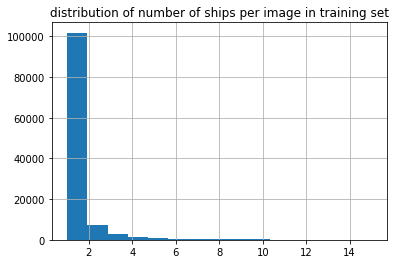

In [10]:
train_ids.hist(bins = 15)
plt.title("distribution of number of ships per image in training set")

Text(0.5, 1.0, 'distribution of number of ships per image in training set')

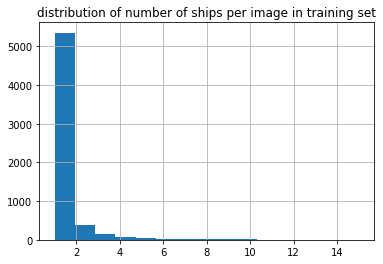

In [11]:
valid_ids.hist(bins = 15)
plt.title("distribution of number of ships per image in training set")

In [7]:
print(train_df.ImageId.nunique(), 'unique images in train set')

116428 unique images in train set


In [8]:
print(valid_df.ImageId.nunique(),'unique images in test set')

6128 unique images in test set


### 2) Creating the datasets:

In [9]:
class ShipDataset(Dataset):
    def __init__(self, in_df, transform=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transform = transform
        self.mode = mode
        self.img_transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if self.mode == 'train':
            rgb_path = os.path.join(train_image_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_image_dir, img_file_name)
        img = imread(rgb_path)
        mask = masks_as_image(self.image_masks[idx])
       
        if self.transform is not None:
            img, mask = self.transform(img, mask)

        if self.mode == 'train':
            #return self.to_float_tensor(img), self.to_float_tensor(mask)
            #eturn img, mask
            return self.img_transform(img), torch.from_numpy(np.moveaxis(mask, -1, 0)).float()
        else:
            return self.img_transform(img), str(img_file_name)

In [10]:
def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

def cuda(x):
    return x.cuda(non_blocking=True) if torch.cuda.is_available() else x

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()

In [11]:
#Create dataset
dataset_valid = ShipDataset(valid_df)

In [12]:
dataset_valid.__getitem__(2)[1].shape

torch.Size([1, 768, 768])

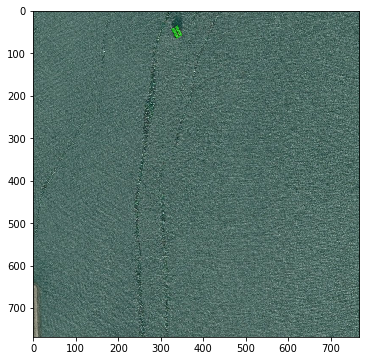

In [13]:
#To show image with its mask

imshow(*dataset_valid[0])

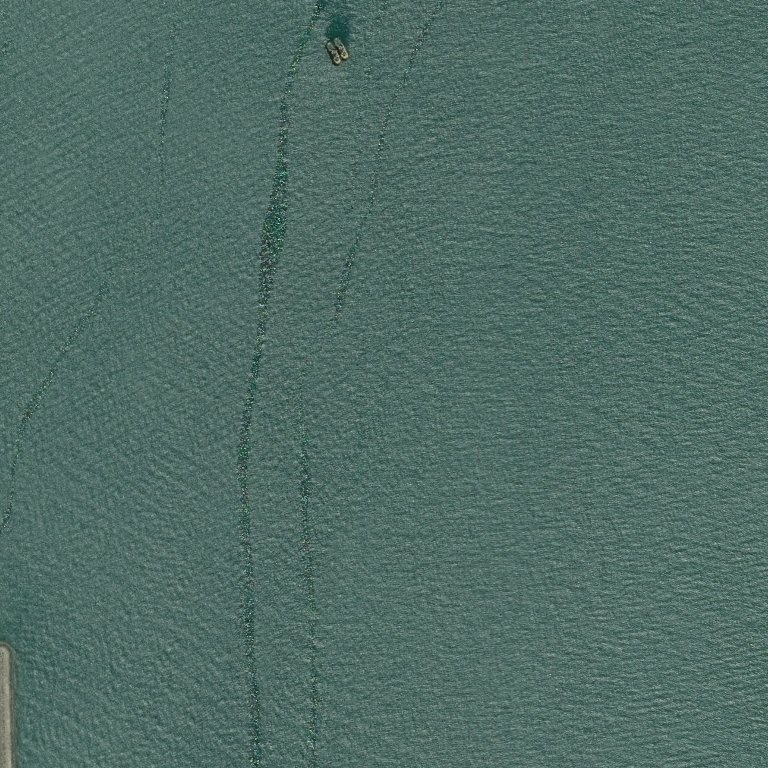

In [14]:
#to see the original version we can use: 
from PIL import Image
Image.open("train_v2/0002756f7.jpg")

Below some data augmentation techniques:

In [15]:
"""
    Implementation from  https://github.com/ternaus/robot-surgery-segmentation
"""

def clip(img, dtype, maxval):
    return np.clip(img, 0, maxval).astype(dtype)

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x, mask=None):
        for t in self.transforms:
            x, mask = t(x, mask)
        return x, mask
    
class ImageOnly:
    def __init__(self, trans):
        self.trans = trans

    def __call__(self, x, mask=None):
        return self.trans(x), mask


class VerticalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 0)
            if mask is not None:
                mask = cv2.flip(mask, 0)
        return img, mask


class HorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            img = cv2.flip(img, 1)
            if mask is not None:
                mask = cv2.flip(mask, 1)
        return img, mask


class RandomFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            d = random.randint(-1, 1)
            img = cv2.flip(img, d)
            if mask is not None:
                mask = cv2.flip(mask, d)
        return img, mask

class RandomRotate90:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, img, mask=None):
        if random.random() < self.prob:
            factor = random.randint(0, 4)
            img = np.rot90(img, factor)
            if mask is not None:
                mask = np.rot90(mask, factor)
        return img.copy(), mask.copy()

class RandomCrop:
    def __init__(self, size):
        self.h = size[0]
        self.w = size[1]

    def __call__(self, img, mask=None):
        height, width, _ = img.shape

        h_start = np.random.randint(0, height - self.h)
        w_start = np.random.randint(0, width - self.w)

        img = img[h_start: h_start + self.h, w_start: w_start + self.w,:]

        assert img.shape[0] == self.h
        assert img.shape[1] == self.w

        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[h_start: h_start + self.h, w_start: w_start + self.w,:]

        return img, mask

class RandomBrightness:
    def __init__(self, limit=0.1, prob=0.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            alpha = 1.0 + self.limit * random.uniform(-1, 1)

            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[..., :3] = clip(alpha * img[..., :3], dtype, maxval)
        return img


class RandomContrast:
    def __init__(self, limit=.1, prob=.5):
        self.limit = limit
        self.prob = prob

    def __call__(self, img):
        if random.random() < self.prob:
            alpha = 1.0 + self.limit * random.uniform(-1, 1)

            gray = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2GRAY)
            gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
            maxval = np.max(img[..., :3])
            dtype = img.dtype
            img[:, :, :3] = clip(alpha * img[:, :, :3] + gray, dtype, maxval)
        return img
class CenterCrop:
    def __init__(self, size):
        self.height = size[0]
        self.width = size[1]

    def __call__(self, img, mask=None):
        h, w, c = img.shape
        dy = (h - self.height) // 2
        dx = (w - self.width) // 2
        y1 = dy
        y2 = y1 + self.height
        x1 = dx
        x2 = x1 + self.width
        img = img[y1:y2, x1:x2,:]
        if mask is not None:
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=2)
            mask = mask[y1:y2, x1:x2,:]

        return img, mask
    


Given the big size of images 768x768, I chose to train the model on smaller images of size 256x256 as a first step

In [16]:
train_transform = DualCompose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomCrop((256,256,3)),
        #ImageOnly(RandomBrightness()),
        #ImageOnly(RandomContrast()),
])

val_transform = DualCompose([
        CenterCrop((512,512,3)),
      ])


Since there is too many images that does not contain any ship, and the number of pixels representing the ships are very few, I chose to train only on the images that has at least one ship to have more balanced classes (ship vs no-ship). This approach can be improved by adding a model to detect for a single image whether it has a ship or not.

In [18]:
train_DF= train_df[train_df['counts']>0]
train_DF.dropna(inplace=True)
valid_DF= valid_df[valid_df['counts']>0]
valid_DF.dropna(inplace=True)

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
valid_DF.shape

(4080, 3)

In [20]:
def make_loader(in_df, batch_size, shuffle=False, transform=None):
        return DataLoader(
            dataset=ShipDataset(in_df, transform=transform),
            shuffle=shuffle,
            num_workers = 0,
            batch_size = batch_size,
            pin_memory=torch.cuda.is_available()
        )


In [21]:

train_loader = make_loader(train_DF, batch_size =  BATCH_SIZE, shuffle=True, transform=train_transform)
valid_loader = make_loader(valid_DF, batch_size = int(BATCH_SIZE / 2), transform=None)

Below we prove that, even after eliminating the images that has no ship, the classification problem for the pixels is still very unbalanced

In [26]:
sum = 0
for _,labels in train_loader:
    sum+= labels.sum(dim=(0,1,2,3)).item()
print(sum)

15719201.0


In [27]:
sum/(256*256*len(train_DF))

0.0030892156703120574

### 3) Useful functions:

##### a. Loss functions:

In [17]:
 class LossBinary:
    """     
    Implementation taken from a notebook in the competition site
    
    I added pos_weight to BCE to have a better Loss since the dataset is not balanced
    """

    def __init__(self, pos_weight = None, jaccard_weight=0):
        if pos_weight != None:
            self.nll_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else :
            self.nll_loss = nn.BCEWithLogitsLoss()
        
        self.jaccard_weight = jaccard_weight
        self.pos_weight = pos_weight
        
    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1.0).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [2]:
 class IoULoss:
    """     
    Loss function that aims to minimize the IoU loss
    """

    def __init__(self):
        self.loss = 1
    def __call__(self, outputs, targets):
        eps = 1e-15
        jaccard_target = (targets == 1.0).float()
        jaccard_output = F.sigmoid(outputs)

        intersection = (jaccard_output * jaccard_target).sum()
        union = jaccard_output.sum() + jaccard_target.sum()

        loss = -torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [3]:
 class LossBinaryDice:
    """
    Loss that combines Binary crossentropy loss with logits and dice loss
    """
    def __init__(self, pos_weight = None, jaccard_weight=0):
        if pos_weight != None:
            self.nll_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else :
            self.nll_loss = nn.BCEWithLogitsLoss()
        
        self.jaccard_weight = jaccard_weight
        self.pos_weight = pos_weight
        
    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1.0).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((2*intersection + eps) / (union + eps))
        return loss

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    """
    Ce n'est pas mon implémentation, je l'ai emprunté d'un notebook déjà prêt
    """
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [26]:
def tversky(y_true, y_pred):
    smooth=1

    true_pos = (y_true * y_pred).sum()
    false_neg = (y_true * (1-y_pred)).sum()
    false_pos = ((1-y_true)*y_pred).sum()
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

class tversky_loss:

    def __init__(self, pos_weight = None, jaccard_weight=0):
        self.a = None
        
    def __call__(self, outputs, targets):
        return 1 - tversky(outputs,targets)
   

We will see that after testing many of these loss functions, the best one is the mixed loss between focal loss and dice loss. Here is a link for the focal loss: https://arxiv.org/abs/1708.02002

##### b. Functions for the model:

In [22]:
def acc(predicted, labels):
    return (predicted == labels).sum().item()/labels.size(0)

def IoU(predicted, labels):
    """
    Computes the Intersection Over Union of two images
    """
    inter = (predicted * labels).sum(dim=(0,1,2))
    union = predicted.sum(dim=(0,1,2)) + labels.sum(dim=(0,1,2)) - inter
    eps = 1e-6
    iou = (inter.item()+eps) / (union.item()+eps)
    return iou
    

def accuracy(net, test_loader, cuda=True, metric=acc):
    net.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = labels.sum(dim=1)
            labels = labels.type(torch.FloatTensor) # LongTensor when working with CrossLossEntropy()
            if cuda:
                images = images.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.FloatTensor) # LongTensor when working with CrossLossEntropy()
            outputs = net(images)
            outputs = outputs.sum(dim=1)
            # loss+= criterion(outputs, labels).item()
            #_, predicted = torch.max(outputs.data, 1) # (j'ai enlevé cette ligne pour travailler avec (batch,1,X,X))
            predicted = (outputs>0.5).float() 

            # total += labels.size(0)
            total += 1
            if cuda:
                predicted = predicted.type(torch.cuda.LongTensor)
            correct += metric(predicted, labels) # changer images par predicted

    net.train()
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    return 100.0 * correct 



def train(net, optimizer, criterion, train_loader, test_loader,  n_epoch = 5,
          train_acc_period = 1000,
          test_acc_period = 5,
          cuda=True,
          metric=acc):
    loss_train = []
    loss_test = []
    total = 0
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        #scheduler.step()
        running_loss = 0.0
        running_acc = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            labels = labels.sum(dim=1)
            labels = labels.type(torch.FloatTensor)# LongTensor when working with CrossLossEntropy()
            if cuda:
                inputs = inputs.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.FloatTensor) # LongTensor when working with CrossLossEntropy() 
          # print(inputs.shape)
          # zero the parameter gradients
            optimizer.zero_grad()

          # forward + backward + optimize
            outputs = net(inputs)
            outputs = outputs.sum(dim=1)
            predicted = (outputs>0.5).float() 
          
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
          # print statistics
            running_loss = 0.33*loss.item()/labels.size(0) + 0.66*running_loss


          # correct = (predicted == labels).sum().item()/labels.size(0)
            if cuda:
                predicted = predicted.type(torch.cuda.LongTensor)
            correct = metric(predicted, labels) 

            running_acc = 0.3*correct + 0.66*running_acc

            if i % train_acc_period == train_acc_period-1:
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss))
                print('[%d, %5d] acc: %.3f' %(epoch + 1, i + 1, running_acc))
                running_loss = 0.0
                total = 0
            # break
        if epoch % test_acc_period == test_acc_period-1:
            print('u')
            cur_acc = accuracy(net, test_loader, cuda=cuda, metric=metric)
            # print('[%d] loss: %.3f' %(epoch + 1, cur_loss))
            print('[%d] test acc: %.3f' %(epoch + 1, cur_acc))

    print('Finished Training')

The chosen architecture is a mix of UNet and ResNet. In fact, it's a UNet architecture using ResNet for the encoding part.

In [1]:
import torch.nn as nn
from torchvision import models

def ConvReluBN(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channels)
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.pretrained_model = models.resnet18(pretrained=True)
        self.pretrained_layers = list(self.pretrained_model.children())

        self.Layer0 = nn.Sequential(*self.pretrained_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.Layer0_1x1 = ConvReluBN(64, 64, 1, 0)
        self.Layer1 = nn.Sequential(*self.pretrained_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.Layer1_1x1 = ConvReluBN(64, 64, 1, 0)
        self.Layer2 = self.pretrained_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.Layer2_1x1 = ConvReluBN(128, 128, 1, 0)
        self.Layer3 = self.pretrained_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.Layer3_1x1 = ConvReluBN(256, 256, 1, 0)
        self.Layer4 = self.pretrained_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.Layer4_1x1 = ConvReluBN(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = ConvReluBN(256 + 512, 512, 3, 1)
        self.conv_up2 = ConvReluBN(128 + 512, 256, 3, 1)
        self.conv_up1 = ConvReluBN(64 + 256, 256, 3, 1)
        self.conv_up0 = ConvReluBN(64 + 256, 128, 3, 1)

        self.conv_original_size0 = ConvReluBN(3, 64, 3, 1)
        self.conv_original_size1 = ConvReluBN(64, 64, 3, 1)
        self.conv_original_size2 = ConvReluBN(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.Layer0(input)
        layer1 = self.Layer1(layer0)
        layer2 = self.Layer2(layer1)
        layer3 = self.Layer3(layer2)
        layer4 = self.Layer4(layer3)

        layer4 = self.Layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.Layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.Layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.Layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.Layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out


### 4) Training and validation of the model:

In [32]:
net3 = ResNetUNet(1)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net3.cuda()
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
net3 = net3.to(device)
learning_rate = 5e-4
optimizer3 = torch.optim.Adam(net3.parameters(),lr=learning_rate)
pos_weight = torch.ones([256,256])*997
pos_weight = pos_weight.type(torch.cuda.LongTensor)
criterion3 = LossBinary(pos_weight=pos_weight, jaccard_weight=5)


train(net3,
      optimizer3,
      criterion3,
      train_loader,
      valid_loader,
      n_epoch = 5,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 5,
      metric=IoU)

accuracy(net3, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

using cuda
[1,   200] loss: 0.907
[1,   200] acc: 0.125
[1,   400] loss: 0.853
[1,   400] acc: 0.123
[1,   600] loss: 0.861
[1,   600] acc: 0.256
[1,   800] loss: 5.693
[1,   800] acc: 0.135
[1,  1000] loss: 2.087
[1,  1000] acc: 0.227
[1,  1200] loss: 1.993
[1,  1200] acc: 0.259
[1,  1400] loss: 0.747
[1,  1400] acc: 0.184
[1,  1600] loss: 0.736
[1,  1600] acc: 0.282
[1,  1800] loss: 5.241
[1,  1800] acc: 0.261
[1,  2000] loss: 0.711
[1,  2000] acc: 0.149
[1,  2200] loss: 1.181
[1,  2200] acc: 0.135
[1,  2400] loss: 0.897
[1,  2400] acc: 0.272
[1,  2600] loss: 1.295
[1,  2600] acc: 0.112
[2,   200] loss: 1.139
[2,   200] acc: 0.134
[2,   400] loss: 0.620
[2,   400] acc: 0.360
[2,   600] loss: 0.546
[2,   600] acc: 0.360
[2,   800] loss: 1.675
[2,   800] acc: 0.153
[2,  1000] loss: 0.918
[2,  1000] acc: 0.121
[2,  1200] loss: 1.673
[2,  1200] acc: 0.399
[2,  1400] loss: 1.295
[2,  1400] acc: 0.176
[2,  1600] loss: 1.017
[2,  1600] acc: 0.072
[2,  1800] loss: 0.481
[2,  1800] acc: 0.332

12948.833459398913

In [26]:
net4 = ResNetUNet(1)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net4.cuda()
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
net4 = net4.to(device)
learning_rate = 1e-3
optimizer4 = torch.optim.Adam(net4.parameters(),lr=learning_rate)
pos_weight = torch.ones([256,256])*87
pos_weight = pos_weight.type(torch.cuda.LongTensor)
criterion4 = LossBinary(pos_weight=pos_weight, jaccard_weight=5)


train(net4,
      optimizer4,
      criterion4,
      train_loader,
      valid_loader,
      n_epoch = 3,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 5,
      metric=IoU)

accuracy(net4, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

using cuda


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   200] loss: 1.233
[1,   200] acc: 0.235
[1,   400] loss: 0.716
[1,   400] acc: 0.170
[1,   600] loss: 1.008
[1,   600] acc: 0.152
[1,   800] loss: 0.613
[1,   800] acc: 0.211
[1,  1000] loss: 0.706
[1,  1000] acc: 0.283
[1,  1200] loss: 0.849
[1,  1200] acc: 0.137
[1,  1400] loss: 0.437
[1,  1400] acc: 0.361
[1,  1600] loss: 0.918
[1,  1600] acc: 0.167
[1,  1800] loss: 0.659
[1,  1800] acc: 0.320
[1,  2000] loss: 0.468
[1,  2000] acc: 0.369
[1,  2200] loss: 0.752
[1,  2200] acc: 0.185
[1,  2400] loss: 1.260
[1,  2400] acc: 0.164
[1,  2600] loss: 2.292
[1,  2600] acc: 0.066
[2,   200] loss: 0.641
[2,   200] acc: 0.250
[2,   400] loss: 0.828
[2,   400] acc: 0.270
[2,   600] loss: 3.237
[2,   600] acc: 0.164
[2,   800] loss: 0.689
[2,   800] acc: 0.220
[2,  1000] loss: 2.140
[2,  1000] acc: 0.115
[2,  1200] loss: 0.687
[2,  1200] acc: 0.438
[2,  1400] loss: 0.384
[2,  1400] acc: 0.416
[2,  1600] loss: 0.780
[2,  1600] acc: 0.166
[2,  1800] loss: 0.319
[2,  1800] acc: 0.435
[2,  2000]

13064.742729237856

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


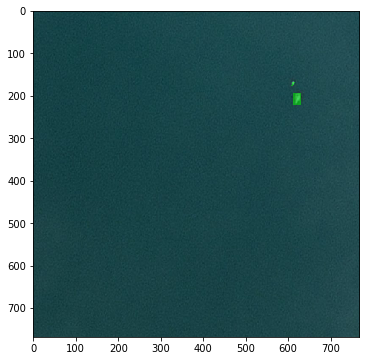

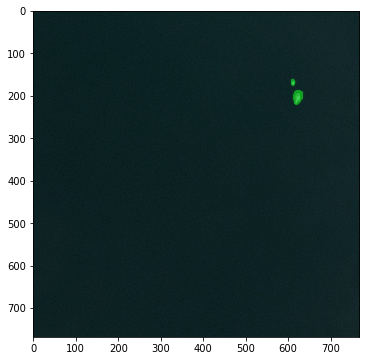

In [63]:
img,real_mask = dataset_valid[512]
input_img = torch.unsqueeze(variable(img, volatile=True), dim=0)
mask = nn.Sigmoid()(net4(input_img))
out_mask = torch.squeeze(mask.data.cpu(), dim = 0)
imshow(img,real_mask)
imshow(img,out_mask)


In [27]:
net9 = ResNetUNet(1)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net9.cuda()
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
net9 = net9.to(device)
learning_rate = 5e-4
optimizer9 = torch.optim.Adam(net9.parameters(),lr=learning_rate)
pos_weight = torch.ones([256,256])*87
pos_weight = pos_weight.type(torch.cuda.LongTensor)
criterion9 = LossBinary(pos_weight=pos_weight, jaccard_weight=5)


train(net9,
      optimizer9,
      criterion9,
      train_loader,
      valid_loader,
      n_epoch = 3,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 5,
      metric=IoU)

accuracy(net9, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

using cuda


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   200] loss: 0.619
[1,   200] acc: 0.260
[1,   400] loss: 0.537
[1,   400] acc: 0.335
[1,   600] loss: 0.417
[1,   600] acc: 0.405
[1,   800] loss: 0.721
[1,   800] acc: 0.302
[1,  1000] loss: 0.324
[1,  1000] acc: 0.378
[1,  1200] loss: 0.630
[1,  1200] acc: 0.221
[1,  1400] loss: 0.483
[1,  1400] acc: 0.314
[1,  1600] loss: 1.038
[1,  1600] acc: 0.279
[1,  1800] loss: 0.450
[1,  1800] acc: 0.347
[1,  2000] loss: 0.751
[1,  2000] acc: 0.219
[1,  2200] loss: 0.681
[1,  2200] acc: 0.350
[1,  2400] loss: 0.511
[1,  2400] acc: 0.263
[1,  2600] loss: 0.475
[1,  2600] acc: 0.353
[2,   200] loss: 0.574
[2,   200] acc: 0.350
[2,   400] loss: 1.539
[2,   400] acc: 0.224
[2,   600] loss: 0.496
[2,   600] acc: 0.262
[2,   800] loss: 0.452
[2,   800] acc: 0.358
[2,  1000] loss: 0.637
[2,  1000] acc: 0.296
[2,  1200] loss: 0.521
[2,  1200] acc: 0.245
[2,  1400] loss: 0.341
[2,  1400] acc: 0.494
[2,  1600] loss: 0.609
[2,  1600] acc: 0.362
[2,  1800] loss: 0.664
[2,  1800] acc: 0.245
[2,  2000]

14780.527535991712

In [28]:
net10 = ResNetUNet(1)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net10.cuda()
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
net10 = net10.to(device)
learning_rate = 5e-4
optimizer10 = torch.optim.Adam(net10.parameters(),lr=learning_rate)
pos_weight = torch.ones([256,256])*10
pos_weight = pos_weight.type(torch.cuda.LongTensor)
criterion10 = LossBinaryDice(pos_weight=pos_weight, jaccard_weight=5)


train(net10,
      optimizer10,
      criterion10,
      train_loader,
      valid_loader,
      n_epoch = 5,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 4,
      metric=IoU)

accuracy(net10, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

using cuda
[1,   200] loss: 0.710
[1,   200] acc: 0.175
[1,   400] loss: 0.862
[1,   400] acc: 0.155
[1,   600] loss: 0.775
[1,   600] acc: 0.409
[1,   800] loss: 0.595
[1,   800] acc: 0.279
[1,  1000] loss: 0.558
[1,  1000] acc: 0.245
[1,  1200] loss: 1.010
[1,  1200] acc: 0.154
[1,  1400] loss: 0.574
[1,  1400] acc: 0.368
[1,  1600] loss: 0.827
[1,  1600] acc: 0.333
[1,  1800] loss: 0.540
[1,  1800] acc: 0.284
[1,  2000] loss: 0.459
[1,  2000] acc: 0.358
[1,  2200] loss: 0.777
[1,  2200] acc: 0.193
[1,  2400] loss: 0.933
[1,  2400] acc: 0.155
[1,  2600] loss: 0.547
[1,  2600] acc: 0.277
[2,   200] loss: 0.527
[2,   200] acc: 0.296
[2,   400] loss: 3.786
[2,   400] acc: 0.221
[2,   600] loss: 3.492
[2,   600] acc: 0.250
[2,   800] loss: 4.939
[2,   800] acc: 0.238
[2,  1000] loss: 0.712
[2,  1000] acc: 0.156
[2,  1200] loss: 0.739
[2,  1200] acc: 0.195
[2,  1400] loss: 0.563
[2,  1400] acc: 0.256
[2,  1600] loss: 0.550
[2,  1600] acc: 0.337
[2,  1800] loss: 0.509
[2,  1800] acc: 0.341

13720.395672831335

In [13]:
!pip install torch-lr-finder -v --global-option="amp"


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Non-user install because site-packages writeable
Created temporary directory: /tmp/pip-ephem-wheel-cache-96_62h5q
Created temporary directory: /tmp/pip-req-tracker-3ni1a8cl
Initialized build tracking at /tmp/pip-req-tracker-3ni1a8cl
Created build tracker: /tmp/pip-req-tracker-3ni1a8cl
Entered build tracker: /tmp/pip-req-tracker-3ni1a8cl
Created temporary directory: /tmp/pip-install-migfacv8
1 location(s) to search for versions of torch-lr-finder:
* https://pypi.org/simple/torch-lr-finder/
Fetching project page and analyzing links: https://pypi.org/simple/torch-lr-finder/
Getting page https://pypi.org/simple/torch-lr-finder/
Found index url https://pypi.org/simple
Looking up "https://pypi.org/simple/torch-lr-finder/" in the cache
Reque

Skipping wheel build for torch-lr-finder, due to binaries being disabled for it.
  Created temporary directory: /tmp/pip-record-bm3at6t9
    Running command /anaconda/envs/py37_pytorch/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-migfacv8/torch-lr-finder/setup.py'"'"'; __file__='"'"'/tmp/pip-install-migfacv8/torch-lr-finder/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' amp install --record /tmp/pip-record-bm3at6t9/install-record.txt --single-version-externally-managed --compile --install-headers /anaconda/envs/py37_pytorch/include/python3.7m/torch-lr-finder
    Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
    To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
    /anaconda/envs/py37_pytorch/lib/python3.7/site-packages/pip/_intern

    1 location(s) to search for versions of pip:
    * https://pypi.org/simple/pip/
    Fetching project page and analyzing links: https://pypi.org/simple/pip/
    Getting page https://pypi.org/simple/pip/
    Found index url https://pypi.org/simple
    Starting new HTTPS connection (1): pypi.org:443
    https://pypi.org:443 "GET /simple/pip/ HTTP/1.1" 200 13603
      Found link https://files.pythonhosted.org/packages/3d/9d/1e313763bdfb6a48977b65829c6ce2a43eaae29ea2f907c8bbef024a7219/pip-0.2.tar.gz#sha256=88bb8d029e1bf4acd0e04d300104b7440086f94cc1ce1c5c3c31e3293aee1f81 (from https://pypi.org/simple/pip/), version: 0.2
      Found link https://files.pythonhosted.org/packages/18/ad/c0fe6cdfe1643a19ef027c7168572dac6283b80a384ddf21b75b921877da/pip-0.2.1.tar.gz#sha256=83522005c1266cc2de97e65072ff7554ac0f30ad369c3b02ff3a764b962048da (from https://pypi.org/simple/pip/), version: 0.2.1
      Found link https://files.pythonhosted.org/packages/17/05/f66144ef69b436d07f8eeeb28b7f77137f80de4bf60349

      Found link https://files.pythonhosted.org/packages/77/3e/6a1fd8e08a06e3e0f54182c7c937bba3f4e9cf1b26f54946d3915021ea2e/pip-20.2b1.tar.gz#sha256=dbf65ecb1c30d35d72f5fda052fcd2f1ea9aca8eaf03d930846d990f51d3f6f6 (from https://pypi.org/simple/pip/) (requires-python:>=2.7,!=3.0.*,!=3.1.*,!=3.2.*,!=3.3.*,!=3.4.*), version: 20.2b1
    Given no hashes to check 139 links for project 'pip': discarding no candidates
    running install
    running build
    running build_py
    creating build
    creating build/lib
    creating build/lib/torch_lr_finder
    copying torch_lr_finder/__init__.py -> build/lib/torch_lr_finder
    copying torch_lr_finder/lr_finder.py -> build/lib/torch_lr_finder
    running install_lib
    creating /anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch_lr_finder
    copying build/lib/torch_lr_finder/__init__.py -> /anaconda/envs/py37_pytorch/lib/python3.7/site-packages/torch_lr_finder
    copying build/lib/torch_lr_finder/lr_finder.py -> /anaconda/envs/py37

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


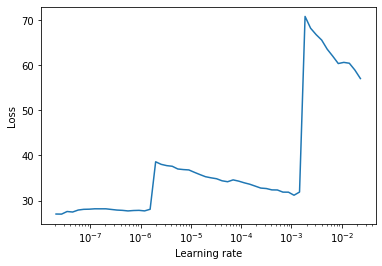

In [27]:
from torch_lr_finder import LRFinder

model = ResNetUNet(1)
pos_weight = torch.ones([256,256])*333
pos_weight = pos_weight.type(torch.cuda.LongTensor)
criterion = LossBinary(pos_weight=pos_weight, jaccard_weight=5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-9, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [30]:
torch.save(net10,'net10.pth')

In [31]:
net11 = ResNetUNet(1)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net11.cuda()
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
net11 = net11.to(device)
learning_rate = 1e-4
optimizer11 = torch.optim.Adam(net11.parameters(),lr=learning_rate)
pos_weight = torch.ones([256,256])*87
pos_weight = pos_weight.type(torch.cuda.LongTensor)
criterion11 = LossBinary(pos_weight=pos_weight, jaccard_weight=5)

train(net11,
      optimizer11,
      criterion11,
      train_loader,
      valid_loader,
      n_epoch = 3,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 5,
      metric=IoU)

accuracy(net11, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

using cuda
[1,   200] loss: 0.431
[1,   200] acc: 0.350
[1,   400] loss: 0.357
[1,   400] acc: 0.413
[1,   600] loss: 0.568
[1,   600] acc: 0.267
[1,   800] loss: 0.279
[1,   800] acc: 0.453
[1,  1000] loss: 0.430
[1,  1000] acc: 0.365
[1,  1200] loss: 2.405
[1,  1200] acc: 0.152
[1,  1400] loss: 0.694
[1,  1400] acc: 0.296
[1,  1600] loss: 3.301
[1,  1600] acc: 0.321
[1,  1800] loss: 0.404
[1,  1800] acc: 0.440
[1,  2000] loss: 0.357
[1,  2000] acc: 0.431
[1,  2200] loss: 0.383
[1,  2200] acc: 0.420
[1,  2400] loss: 0.349
[1,  2400] acc: 0.355
[1,  2600] loss: 0.503
[1,  2600] acc: 0.348
[2,   200] loss: 0.417
[2,   200] acc: 0.381
[2,   400] loss: 0.229
[2,   400] acc: 0.530
[2,   600] loss: 1.122
[2,   600] acc: 0.508
[2,   800] loss: 0.597
[2,   800] acc: 0.279
[2,  1000] loss: 0.404
[2,  1000] acc: 0.393
[2,  1200] loss: 0.231
[2,  1200] acc: 0.524
[2,  1400] loss: 3.193
[2,  1400] acc: 0.462
[2,  1600] loss: 0.185
[2,  1600] acc: 0.564
[2,  1800] loss: 0.203
[2,  1800] acc: 0.560

17921.0412547121

In [33]:
torch.save(net11,'net11.pth')

In [35]:
net4 = torch.load('net4.pth')

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


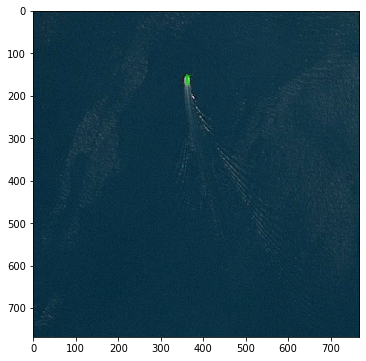

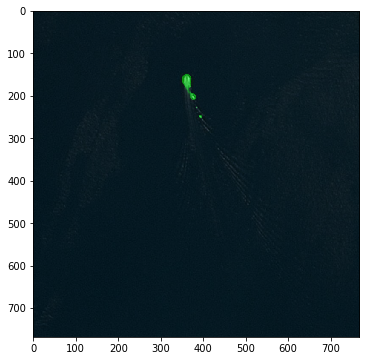

In [41]:
img,real_mask = dataset_valid[501]
input_img = torch.unsqueeze(variable(img, volatile=True), dim=0)
mask = nn.Sigmoid()(net11(input_img))
out_mask = torch.squeeze(mask.data.cpu(), dim = 0)
imshow(img,real_mask)
imshow(img,out_mask)


In [42]:
net12 = ResNetUNet(1)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net12.cuda()
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
net12 = net12.to(device)
learning_rate = 1e-4
optimizer12 = torch.optim.Adam(net12.parameters(),lr=learning_rate)
pos_weight = torch.ones([256,256])*87
pos_weight = pos_weight.type(torch.cuda.LongTensor)
criterion12 = LossBinary(pos_weight=pos_weight, jaccard_weight=5)


train(net12,
      optimizer12,
      criterion12,
      train_loader,
      valid_loader,
      n_epoch = 2,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 5,
      metric=IoU)

accuracy(net12, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

using cuda
[1,   200] loss: 0.394
[1,   200] acc: 0.390
[1,   400] loss: 0.490
[1,   400] acc: 0.359
[1,   600] loss: 0.849
[1,   600] acc: 0.450
[1,   800] loss: 0.533
[1,   800] acc: 0.329
[1,  1000] loss: 0.442
[1,  1000] acc: 0.400
[1,  1200] loss: 1.208
[1,  1200] acc: 0.386
[1,  1400] loss: 0.194
[1,  1400] acc: 0.580
[1,  1600] loss: 0.856
[1,  1600] acc: 0.438
[1,  1800] loss: 0.454
[1,  1800] acc: 0.409
[1,  2000] loss: 0.358
[1,  2000] acc: 0.409
[1,  2200] loss: 0.361
[1,  2200] acc: 0.443
[1,  2400] loss: 0.491
[1,  2400] acc: 0.365
[1,  2600] loss: 0.318
[1,  2600] acc: 0.440
[2,   200] loss: 0.227
[2,   200] acc: 0.554
[2,   400] loss: 0.276
[2,   400] acc: 0.464
[2,   600] loss: 0.317
[2,   600] acc: 0.596
[2,   800] loss: 0.217
[2,   800] acc: 0.592
[2,  1000] loss: 0.197
[2,  1000] acc: 0.579
[2,  1200] loss: 1.687
[2,  1200] acc: 0.322
[2,  1400] loss: 0.403
[2,  1400] acc: 0.364
[2,  1600] loss: 0.519
[2,  1600] acc: 0.351
[2,  1800] loss: 0.279
[2,  1800] acc: 0.448

RuntimeError: CUDA out of memory. Tried to allocate 2.95 GiB (GPU 0; 11.92 GiB total capacity; 6.04 GiB already allocated; 1.94 GiB free; 9.69 GiB reserved in total by PyTorch)

In [25]:
#Since we run out of memory just before printing the accuracy on the validation data, we will load the trained model 
net12=torch.load('net12.pth')

In [27]:
use_cuda = True
accuracy(net12, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

Accuracy of the network on the test images: 61 %


18513.282071290476

In [31]:
net11=torch.load('net11.pth')

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


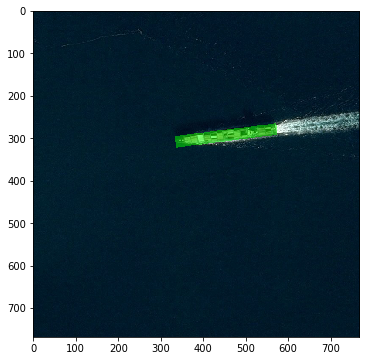

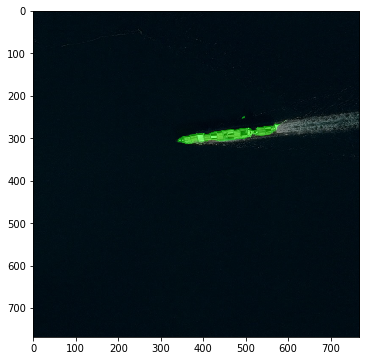

In [43]:
img,real_mask = dataset_valid[5117]
input_img = torch.unsqueeze(variable(img, volatile=True), dim=0)
mask = nn.Sigmoid()(net11(input_img))
out_mask = torch.squeeze(mask.data.cpu(), dim = 0)
imshow(img,real_mask)
imshow(img,out_mask)


To further improve the results, we will use a pretrained model on the famous dataset imagenet. 
The strategy of training is:
* Start by training the pretrained model with a relatively big learning rate on images of size 256x256 for 3 epochs
* Fine tuning the model by a smaller learning rate on the same images for 3 epochs
* Finishing by training the model on the real size of the images for 1 epoch (given that this step takes too much time)

In [26]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [27]:
import segmentation_models_pytorch as smp

In [53]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    model.cuda()
device = torch.device("cuda:0" if (torch.cuda.is_available() and use_cuda) else "cpu")
model = model.to(device)
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
pos_weight = torch.ones([256,256])*333
pos_weight = pos_weight.type(torch.cuda.LongTensor)
criterion = MixedLoss(alpha=1,gamma=2)

train(model,
      optimizer,
      criterion,
      train_loader,
      valid_loader,
      n_epoch = 3,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 5,
      metric=IoU)

accuracy(model, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

using cuda
[1,   200] loss: 0.270
[1,   200] acc: 0.103
[1,   400] loss: 0.199
[1,   400] acc: 0.284
[1,   600] loss: 0.206
[1,   600] acc: 0.265
[1,   800] loss: 0.118
[1,   800] acc: 0.417
[1,  1000] loss: 0.124
[1,  1000] acc: 0.389
[1,  1200] loss: 0.099
[1,  1200] acc: 0.334
[1,  1400] loss: 0.150
[1,  1400] acc: 0.269
[1,  1600] loss: 0.170
[1,  1600] acc: 0.252
[1,  1800] loss: 0.116
[1,  1800] acc: 0.380
[1,  2000] loss: 0.115
[1,  2000] acc: 0.491
[1,  2200] loss: 0.076
[1,  2200] acc: 0.322
[1,  2400] loss: 0.052
[1,  2400] acc: 0.494
[1,  2600] loss: 0.102
[1,  2600] acc: 0.234
[2,   200] loss: 0.072
[2,   200] acc: 0.354
[2,   400] loss: 0.019
[2,   400] acc: 0.590
[2,   600] loss: 0.055
[2,   600] acc: 0.313
[2,   800] loss: 0.076
[2,   800] acc: 0.293
[2,  1000] loss: 0.026
[2,  1000] acc: 0.515
[2,  1200] loss: 0.072
[2,  1200] acc: 0.259
[2,  1400] loss: 0.198
[2,  1400] acc: 0.360
[2,  1600] loss: 0.062
[2,  1600] acc: 0.334
[2,  1800] loss: 0.027
[2,  1800] acc: 0.507

18293.45417636204

In [55]:
torch.save(model,'model.pth')

In [56]:
learning_rate = 1e-6
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = MixedLoss(alpha=1,gamma=2)

train(model,
      optimizer,
      criterion,
      train_loader,
      valid_loader,
      n_epoch = 3,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 5,
      metric=IoU)

accuracy(model, test_loader=valid_loader, cuda=use_cuda, metric=IoU)

[1,   200] loss: 0.023
[1,   200] acc: 0.513
[1,   400] loss: 0.025
[1,   400] acc: 0.496
[1,   600] loss: 0.036
[1,   600] acc: 0.467
[1,   800] loss: 0.055
[1,   800] acc: 0.384
[1,  1000] loss: 0.062
[1,  1000] acc: 0.303
[1,  1200] loss: 0.011
[1,  1200] acc: 0.681
[1,  1400] loss: 0.012
[1,  1400] acc: 0.653
[1,  1600] loss: 0.015
[1,  1600] acc: 0.612
[1,  1800] loss: 0.038
[1,  1800] acc: 0.472
[1,  2000] loss: 0.168
[1,  2000] acc: 0.177
[1,  2200] loss: 0.099
[1,  2200] acc: 0.490
[1,  2400] loss: 0.028
[1,  2400] acc: 0.503
[1,  2600] loss: 0.025
[1,  2600] acc: 0.571
[2,   200] loss: 0.014
[2,   200] acc: 0.623
[2,   400] loss: 0.039
[2,   400] acc: 0.515
[2,   600] loss: 0.066
[2,   600] acc: 0.462
[2,   800] loss: 0.037
[2,   800] acc: 0.475
[2,  1000] loss: 0.014
[2,  1000] acc: 0.636
[2,  1200] loss: 0.017
[2,  1200] acc: 0.575
[2,  1400] loss: 0.025
[2,  1400] acc: 0.488
[2,  1600] loss: 0.028
[2,  1600] acc: 0.570
[2,  1800] loss: 0.037
[2,  1800] acc: 0.489
[2,  2000]

20188.083048371827

In [21]:
model = torch.load('model_better.pth')

In [21]:
train_DF.shape

(77643, 3)

In [22]:
train_loader = make_loader(train_DF, batch_size =  5, shuffle=True, transform=None)
valid_loader = make_loader(valid_DF, batch_size = int(BATCH_SIZE / 2), transform=None)

In [23]:
learning_rate = 8e-6
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = MixedLoss(alpha=1,gamma=2)
use_cuda = True
train(model,
      optimizer,
      criterion,
      train_loader,
      valid_loader,
      n_epoch = 1,
      cuda=use_cuda,
      train_acc_period = 200,
      test_acc_period = 5,
      metric=IoU)

accuracy(model, test_loader=valid_loader, cuda=use_cuda, metric=IoU)


torch.save(model,'model_best.pth')

[1,   200] loss: 0.054
[1,   200] acc: 0.569
[1,   400] loss: 0.056
[1,   400] acc: 0.576
[1,   600] loss: 0.041
[1,   600] acc: 0.631
[1,   800] loss: 0.036
[1,   800] acc: 0.652
[1,  1000] loss: 0.048
[1,  1000] acc: 0.598
[1,  1200] loss: 0.048
[1,  1200] acc: 0.600
[1,  1400] loss: 0.036
[1,  1400] acc: 0.651
[1,  1600] loss: 0.029
[1,  1600] acc: 0.689
[1,  1800] loss: 0.030
[1,  1800] acc: 0.682
[1,  2000] loss: 0.054
[1,  2000] acc: 0.591
[1,  2200] loss: 0.037
[1,  2200] acc: 0.643
[1,  2400] loss: 0.048
[1,  2400] acc: 0.628
[1,  2600] loss: 0.026
[1,  2600] acc: 0.697
[1,  2800] loss: 0.061
[1,  2800] acc: 0.557
[1,  3000] loss: 0.046
[1,  3000] acc: 0.606
[1,  3200] loss: 0.031
[1,  3200] acc: 0.677
[1,  3400] loss: 0.027
[1,  3400] acc: 0.696
[1,  3600] loss: 0.042
[1,  3600] acc: 0.619
[1,  3800] loss: 0.039
[1,  3800] acc: 0.639
[1,  4000] loss: 0.044
[1,  4000] acc: 0.605
[1,  4200] loss: 0.032
[1,  4200] acc: 0.662
[1,  4400] loss: 0.027
[1,  4400] acc: 0.696
[1,  4600]

22305.81213355105

### 5) Submission:

In [28]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')

15606 test images found


In [29]:
BATCH_SIZE = 1
test_df = pd.DataFrame({'ImageId': test_paths, 'EncodedPixels':None})
from skimage.morphology import binary_opening, disk
#test_df=test_df[:5000]
loader = DataLoader(
        dataset=ShipDataset(test_df, transform=None, mode='predict'),
        shuffle=False,
        batch_size=BATCH_SIZE,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    ) 
    

In [46]:
model = torch.load('model_best.pth')

In [36]:

out_pred_rows = []
for batch_num, (inputs, paths) in enumerate(tqdm(loader, desc='Predict')):
    inputs = variable(inputs, volatile=True)
    outputs = model(inputs)
    for i, image_name in enumerate(paths):
        mask = nn.Sigmoid()(outputs[i,0]).data.cpu().numpy()
        cur_seg = binary_opening(mask>0.5, disk(2))
        cur_rles = multi_rle_encode(cur_seg)
        if len(cur_rles)>0:
            for c_rle in cur_rles:
                out_pred_rows += [{'ImageId': image_name, 'EncodedPixels': c_rle}]
        else:
            out_pred_rows += [{'ImageId': image_name, 'EncodedPixels': None}]

Predict:   0%|          | 0/15606 [00:00<?, ?it/s]/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
Predict: 100%|██████████| 15606/15606 [51:06<00:00,  5.09it/s]


In [68]:
mask = np.ones((256,256))
mask[5] = [0 for i in range(256)]
cur_seg = binary_opening(mask>0.5, disk(2))
cur_rles = multi_rle_encode(cur_seg)

In [69]:
cur_rles

['1 1280', '1537 64000']

In [37]:
submission_df = pd.DataFrame(out_pred_rows)[['ImageId', 'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
submission_df.sample(10)

,ImageId,EncodedPixels
8843,4c99f856e.jpg,338726 7 339493 9 340260 11 341029 11 341797 1...
10375,59661982b.jpg,267526 1 268293 3 269060 5 269829 3 270598 1
6499,387c21cfd.jpg,30415 5 31180 13 31945 17 32712 19 33479 20 34...
20345,ae344d047.jpg,None
19627,a86be5a83.jpg,83735 5 84502 8 85269 11 86037 12 86805 14 875...
10149,57bd7b48f.jpg,75090 1 75857 3 76624 5 77392 5 78159 6 78927 ...
24556,d2b9ec99b.jpg,28671 5 29437 8 30204 10 30971 11 31738 13 325...
11471,6330a080c.jpg,69565 6 70332 8 71099 10 71866 10 72634 9 7340...
5977,349bf6d3b.jpg,437484 4 438249 10 439016 12 439783 14 440550 ...
10064,570a10e64.jpg,194928 3 195695 6 196462 8 197229 10 197996 12...


/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.


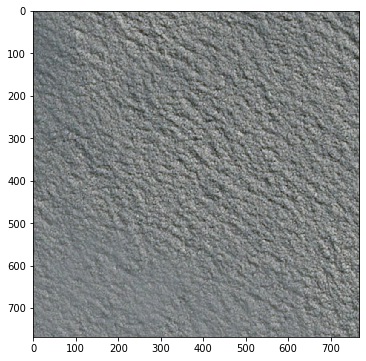

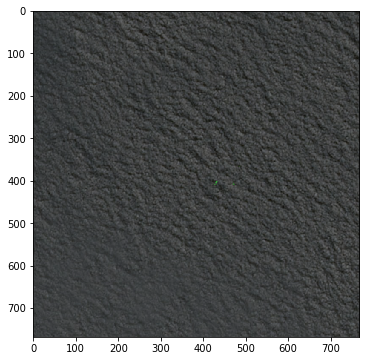

torch.Size([1, 768, 768])


In [61]:
img,real_mask = dataset_valid[5012]
input_img = torch.unsqueeze(variable(img, volatile=True), dim=0)
mask = nn.Sigmoid()(model(input_img))
out_mask = torch.squeeze(mask.data.cpu(), dim = 0)
imshow(img,real_mask)
imshow(img,out_mask)

print(out_mask.shape)